In [1]:
from Qwen2VL_sim.model import Qwen2VLForConditionalGeneration, Qwen2VLProcessor
from qwen_vl_utils import process_vision_info
import torch

In [25]:
model_path = "/data/data1/syc/intern/wanshan/models/Qwen2-VL-2B-Instruct"
device = 'cuda'
min_pixels = 256 * 28 * 28
max_pixels = 512 * 28 * 28

processor = Qwen2VLProcessor.from_pretrained(
    model_path, 
    min_pixels = min_pixels,
    max_pixels = max_pixels
)




In [26]:
img_path = 'chrome.png'
vis_dir = 'visualize_imgs'


messages = [
    {
        "role": "user",
        "content": [
            {"type": "text", "text": "Please describe this image in detail. Explain what is depicted, including all visible components, structures, or elements, "
            "and how they interact with each other. Clarify the purpose of this object or system and the context in which it is typically used. "
            "Additionally, explain why this is important — what problems it helps solve, what needs it fulfills, or what advantages it provides. "
            "If applicable, describe the technology behind it, its functionality, and its role in broader applications. "
            "Your response should be approximately 100 words, providing a comprehensive and informative explanation for better understanding."},
            {
                "type": "image",
                "image": img_path,
                "min_pixels": min_pixels,
                "max_pixels": max_pixels,
            },
        ],
    }
]

# Preparation for inference
text = processor.apply_chat_template(
    messages, tokenize=False, add_generation_prompt=True,
)
print(text)
image_inputs, video_inputs = process_vision_info(messages)
inputs = processor(
    text=[text],
    images=image_inputs,
    videos=video_inputs,
    padding=True,
    return_tensors="pt",
)

inputs = inputs.to(device)

<|im_start|>system
You are a helpful assistant.<|im_end|>
<|im_start|>user
Please describe this image in detail. Explain what is depicted, including all visible components, structures, or elements, and how they interact with each other. Clarify the purpose of this object or system and the context in which it is typically used. Additionally, explain why this is important — what problems it helps solve, what needs it fulfills, or what advantages it provides. If applicable, describe the technology behind it, its functionality, and its role in broader applications. Your response should be approximately 100 words, providing a comprehensive and informative explanation for better understanding.<|vision_start|><|image_pad|><|vision_end|><|im_end|>
<|im_start|>assistant

new w, h 784 476


In [27]:
inputs['pixel_values'].shape[0] / 4

476.0

In [ ]:
model = Qwen2VLForConditionalGeneration.from_pretrained(
    model_path,
    torch_dtype=torch.bfloat16,
    device_map=device,
    vis_dir = './' # token similarity save directory
)

/home/syc/anaconda3/envs/qwen2vl/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:629: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.01` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/home/syc/anaconda3/envs/qwen2vl/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:634: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.001` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
/home/syc/anaconda3/envs/qwen2vl/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:651: UserWarning: `do_sample` is set to `False`. However, `top_k` is set to `1` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_k`.
  warnings.warn(


token similarity visualization is saved
Total Visual Tokens : 1440
Threshold 0.4: 1427 tokens have at least one similar token with score > 0.4.
Threshold 0.5: 1406 tokens have at least one similar token with score > 0.5.
Threshold 0.6: 1377 tokens have at least one similar token with score > 0.6.
Threshold 0.7: 1301 tokens have at least one similar token with score > 0.7.
Threshold 0.8: 1048 tokens have at least one similar token with score > 0.8.
Threshold 0.9: 452 tokens have at least one similar token with score > 0.9.
The image depicts a screenshot of a web browser, specifically Google Chrome, open on a computer. The browser's interface is dark, with a white Google logo prominently displayed in the center. Below the logo, there is a search bar with the placeholder text "Search Google or type a URL." To the right of the search bar, there are two buttons: "Baidu" and "Add shortcut." The "Baidu" button is a placeholder for a search engine that is not currently active. The "Add shortcu

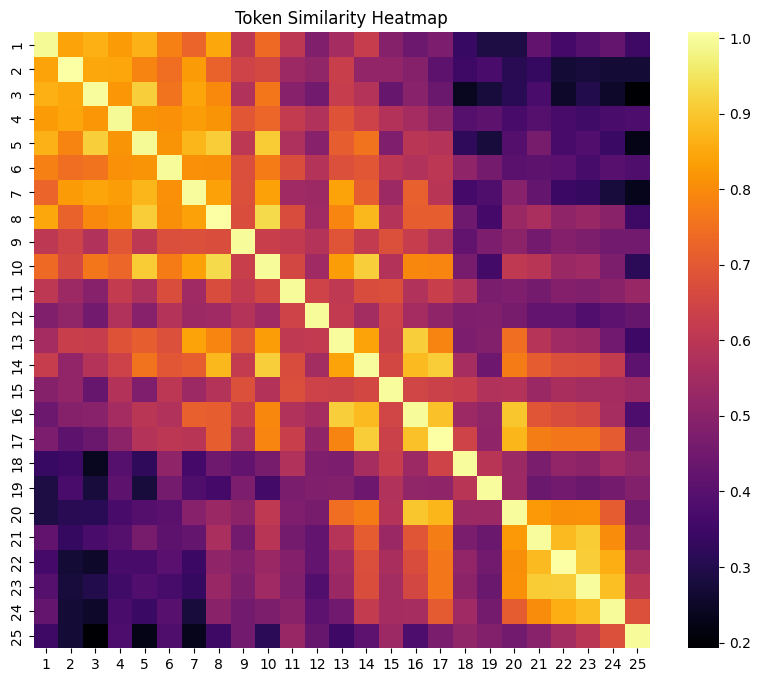

In [4]:
generated_ids = model.generate(
                    **inputs,
                    do_sample=False,
                    max_new_tokens=128,
                    use_cache=True,
                    return_dict_in_generate=True,
                    )
generated_ids_trimmed = [
    out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids['sequences'])
]
output_text = processor.batch_decode(
    generated_ids_trimmed, 
)[0]
print(output_text)
